<a href="https://colab.research.google.com/github/JasmineBW/Image-Classifier/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP3314 HW3: Image Classification

In this project, you could use all the techniques that you learn from this course **(except CNNs)**  to construct an image classifier for the given dataset. You are required to complete the tasks in the following three sections to prepare the dataset, build your classifier, and submit your predictions on the test set.

Important notes:
- TAs will run the code to check the final results. Please make the code executable and keep your executed outputs. If TAs find the executed result does not match the final submission, this submission will receive 0 points.
- Do not use convolutional neural networks (CNNs) in this project.
- Make sure to submit the file in the specified format. Otherwiser, our autograder will not be able to verify your results.
- Do not use any additional datasets or pretrained networks in this project. Do not copy the code or prediction results from others.

## Section 0. Download dataset.

In [ ]:
import cv2
import os
import random
import numpy as np
from pathlib import Path
import urllib.request
import zipfile
import urllib
import hashlib
from tqdm import tqdm

random.seed(0)
np.random.seed(0)

In [ ]:
def download_data(data_dir):
    """
    DO NOT modify the code in this cell.
    
    Args:
        data_dir (Path): Path to the download and extract data directory.

    Returns:
        xs_train: (num_train, 32, 32, 3) uint8
        ys_train: (num_train, ) uint8
        xs_test: (num_test, 32, 32, 3) uint8
    """

    class DownloadProgressBar(tqdm):

        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)

    def compute_md5(file_path):
        file_path = Path(file_path)
        if not file_path.is_file():
            raise ValueError(f"File {file_path} does not exist.")

        with open(file_path, "rb") as f:
            file_hash = hashlib.md5()
            chunk = f.read(8192)
            while chunk:
                file_hash.update(chunk)
                chunk = f.read(8192)

        return str(file_hash.hexdigest())

    def maybe_download_url(url, output_path, md5sum=None):
        output_path = Path(output_path)

        if output_path.is_file() and md5sum is not None:
            if compute_md5(output_path) == md5sum:
                print(f"{output_path} exists and MD5 matches. Skip download.")
                return

        with DownloadProgressBar(unit='B',
                                 unit_scale=True,
                                 miniters=1,
                                 desc=url.split('/')[-1]) as t:
            urllib.request.urlretrieve(url,
                                       filename=output_path,
                                       reporthook=t.update_to)

    # Paths
    data_dir = Path(data_dir)
    data_dir.mkdir(parents=True, exist_ok=True)
    zip_path = data_dir / "data.zip"
    url = "https://github.com/comp3314/hw3-data/releases/download/hw3/data.zip"
    md5sum = "bd4f13ea7b8d9b79c1320fe559698dbd"

    # Download URL
    maybe_download_url(url, zip_path, md5sum=md5sum)

    # Extract zip
    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as f:
        f.extractall(data_dir)
    print("Extracting done.")


def load_data(data_dir):
    data_dir = Path(data_dir)
    if not data_dir.is_dir():
        raise ValueError(f"{data_dir} is not a directory.")

    # Read train
    train_dir = data_dir / "train"
    train_label_path = train_dir / "labels.txt"
    xs_train = []
    ys_train = []
    with open(train_label_path, "r") as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines]
    for line in tqdm(lines, desc="Read train"):
        im_path, im_label = line.split(" ")
        im_path = train_dir / im_path
        im_bgr = cv2.imread(str(im_path))
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        assert im_rgb.shape == (32, 32, 3)
        assert im_rgb.dtype == np.uint8
        xs_train.append(im_rgb)
        ys_train.append(int(im_label))

    # Read test
    test_dir = data_dir / "test"
    test_label_path = test_dir / "labels.txt"
    xs_test = []
    with open(test_label_path, "r") as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines]
    for line in tqdm(lines, desc="Read test"):
        im_path = line
        im_path = test_dir / im_path
        im_bgr = cv2.imread(str(im_path))
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        assert im_rgb.shape == (32, 32, 3)
        assert im_rgb.dtype == np.uint8
        xs_test.append(im_rgb)

    xs_train = np.array(xs_train, dtype=np.uint8)
    ys_train = np.array(ys_train)
    xs_test = np.array(xs_test, dtype=np.uint8)

    return xs_train, ys_train, xs_test

data_dir="data"
download_data(data_dir=data_dir)
xs_train, ys_train, xs_test = load_data(data_dir=data_dir)

xs_train = np.array(xs_train)
ys_train = np.array(ys_train)
xs_test = np.array(xs_test)

print('xs_train: ', xs_train.shape)
print('ys_train: ', ys_train.shape)
print('xs_test: ', xs_test.shape)

data.zip: 77.7MB [00:05, 14.3MB/s]                            


Extracting...
Extracting done.


Read test: 100%|██████████| 10000/10000 [00:00<00:00, 12788.27it/s]


xs_train:  (50000, 32, 32, 3)
ys_train:  (50000,)
xs_test:  (10000, 32, 32, 3)


## Section 1. Dataset preparation. (10 Points)

Before dealing with a new dataset, it is important to know the basic information of the data. 

### Section 1.1. How many categories does this dataset cover? (2 points)

In [ ]:
categories = np.unique(ys_train)
print(categories.size)

10


### Section 1.2. How many train/test samples does each category contain? (3 points)

In [ ]:
count_arr = np.bincount(ys_train)
for each in categories:
  print("Category {}: {}".format(each, count_arr[each]))


Category 0: 5000
Category 1: 5000
Category 2: 5000
Category 3: 5000
Category 4: 5000
Category 5: 5000
Category 6: 5000
Category 7: 5000
Category 8: 5000
Category 9: 5000


### Section 1.3. Visualize one sample for each category. (5 points)

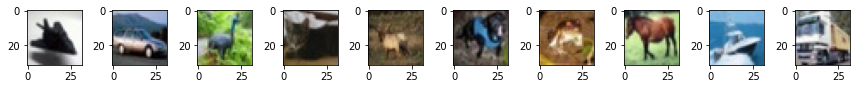

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
test_indexes=[]
  
for i in range(10):
  indexes = np.where(ys_train==i)
  test_indexes.append(indexes[0][0])
  plt.subplot(1,10,i+1)
  plt.imshow(xs_train[test_indexes[i]], cmap="gray")
plt.tight_layout()

## Section 2.  Controlled experiments. (30 Points)

You are required to perform 3 controlled experiments. There are many aspects that you could explore in the controlled experiments, for example:

- Comparisons for different classifiers. 
- Tuning a hyper-parameter for a specific classifier.
- Different pre-processing methods, like normalization, extracting the edge features, grayscale, etc.   
- Ensembling, boosting, or voting methods.
- ...

You are required to explore at least 3 aspects. For each experiment, you should add a subsection in a text cell, and briefly explain your experimental results. To verify your results, you should split the validation set by yourself to carry out experiments to find out the best settings.

### Section 2.1. Controlled experiment I. (10 points)

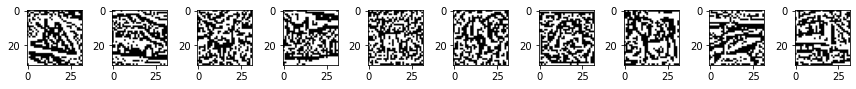

In [ ]:
import matplotlib.pyplot as plt
from scipy.constants import sigma
#change to grayscale to remove color dimension, and remove noise from the image
from skimage.color import rgb2gray
from skimage.filters import threshold_local
import skimage

plt.figure(figsize=(12,12))

for i in range(10):
  plt.subplot(1,10,i+1)
  gray = rgb2gray(xs_train[test_indexes[i]])
  smoothed = skimage.filters.gaussian(gray, sigma=0.1)
  local_thresh = threshold_local(smoothed, block_size=5, offset=0.0005)
  binary_gray = gray > local_thresh
  
  img_edges = skimage.feature.canny(binary_gray)

  plt.imshow(binary_gray, cmap="gray")
plt.tight_layout()

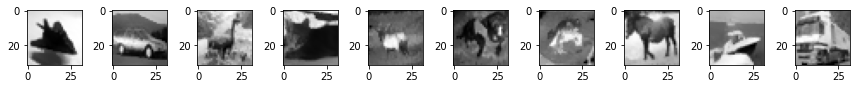

In [ ]:
#change to grayscale to remove color dimension, and remove noise from the image
from skimage.color import rgb2gray
from skimage.restoration import denoise_bilateral
from sklearn.base import BaseEstimator, TransformerMixin

plt.figure(figsize=(12,12))

for i in range(10):
  plt.subplot(1,10,i+1)
  gray = rgb2gray(xs_train[test_indexes[i]])
  denoised_img = denoise_bilateral(gray, sigma_color=0.05)
  plt.imshow(denoised_img, cmap="gray")
plt.tight_layout()

#create gray transformer 
class RGB_to_Gray(BaseEstimator, TransformerMixin):
  
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X_grayed_denoise=[]
    for sample in X:
      gray = rgb2gray(sample)
      X_grayed_denoise.append(denoise_bilateral(gray, sigma_color=0.05))
    return np.array(X_grayed_denoise)

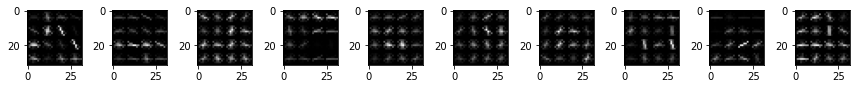

In [ ]:
#create hog transformer for some sort of edge detection
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.base import BaseEstimator, TransformerMixin

plt.figure(figsize=(12,12))

for j in range(10):
  plt.subplot(1,10,j+1)
  gray = rgb2gray(xs_train[test_indexes[j]])
  hog_array, hogged_img = hog(gray, cells_per_block=(2, 2), visualize=True)
  plt.imshow(hogged_img, cmap="gray")
plt.tight_layout()


class Hog_transformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X_hog_array=[]
    for sample in X:
      X_hog_array.append(hog(sample, cells_per_block=(2, 2)))
    return np.array(X_hog_array)

In [ ]:
from sklearn.preprocessing import StandardScaler

gray_transformer = RGB_to_Gray()
hog_transformer = Hog_transformer()
sc = StandardScaler()

X_train_gray = gray_transformer.fit_transform(xs_train)
X_train_hog = hog_transformer.fit_transform(X_train_gray)
X_train_scaled = sc.fit_transform(X_train_hog)

print(X_train_scaled.shape)

(50000, 324)


In [ ]:
#Preprocessing the data
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum>=0.9)+1
print(d)
pca = PCA(n_components=d)
X_train_reduced = pca.fit_transform(X_train_scaled)
print("reduced shape: " + str(X_train_reduced.shape))

98
reduced shape: (50000, 98)


### Section 2.2. Controlled experiment II. (10 points)

In [ ]:
# Classifier comparison (logistic regression, SVM, random forest, KNN)

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold


models = []
model_names = []
results = []

lr = LogisticRegression(max_iter=400, n_jobs=-1, solver='saga')
models.append(('Logistic Regression', lr))

svm = SGDClassifier(n_jobs=-1)
models.append(('SVM', svm))

forest = RandomForestClassifier(n_jobs=-1)
models.append(('Forest', forest))

KNN = KNeighborsClassifier()
models.append(('KNN', KNN))



In [ ]:
for name, model in models:
  skfold = StratifiedKFold(n_splits=50, random_state=1, shuffle=True).split(xs_train, ys_train)
  #print(skfold)
  score = cross_val_score(estimator=model, X=X_train_reduced, y=ys_train, cv=skfold, n_jobs=-1, error_score='raise')
  results.append(score)
  model_names.append(name)
  print('CV accuracy of %s: %.3f +/- %.3f' % (name, np.mean(score), np.std(score)))

### Section 2.3. Controlled experiment II. (10 points)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold


lr = LogisticRegression(max_iter=400, n_jobs=-1, solver='saga')

svm = SGDClassifier(n_jobs=-1)

forest = RandomForestClassifier(n_jobs=-1)

KNN = KNeighborsClassifier(n_jobs=-1)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

forest_estim = [10, 50, 100, 200]
forest_criterion = ['gini', 'entropy']
forest_min_sample_leaf = [1, 5, 20, 50]

param_grid_frst = [{'n_estimators': forest_estim,
               'criterion': forest_criterion,
               'min_samples_leaf': forest_min_sample_leaf}]


rsv = RandomizedSearchCV(estimator=forest, param_distributions=param_grid_frst, scoring="accuracy", cv=100, n_jobs=-1, error_score='raise')
rsv.fit(X_train_reduced[:2501], ys_train[:2501])
print('Best params FRST', rsv.best_params_)
print('Best score FRST', rsv.best_score_)


Best params FRST {'n_estimators': 200, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Best score FRST 0.3934769230769231


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

forest_estim = [10, 50, 100, 200]
forest_criterion = ['gini', 'entropy']
forest_min_sample_leaf = [1, 5, 20, 50]

param_grid_frst = [{'n_estimators': forest_estim,
               'criterion': forest_criterion,
               'min_samples_leaf': forest_min_sample_leaf}]


rsv = RandomizedSearchCV(estimator=forest, param_distributions=param_grid_frst, scoring="accuracy", cv=100, n_jobs=-1, error_score='raise')
rsv.fit(X_train_reduced[2501:3751], ys_train[2501:3751])
print('Best params FRST', rsv.best_params_)
print('Best score FRST', rsv.best_score_)


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 99 members, which is less than n_splits=100.
  warnings.warn(


Best params FRST {'n_estimators': 200, 'min_samples_leaf': 5, 'criterion': 'entropy'}
Best score FRST 0.3748717948717949


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

forest_estim = [10, 50, 100, 200]
forest_criterion = ['gini', 'entropy']
forest_min_sample_leaf = [1, 5, 20, 50]

param_grid_frst = [{'n_estimators': forest_estim,
               'criterion': forest_criterion,
               'min_samples_leaf': forest_min_sample_leaf}]


rsv = RandomizedSearchCV(estimator=forest, param_distributions=param_grid_frst, scoring="accuracy", cv=100, n_jobs=-1, error_score='raise')
rsv.fit(X_train_reduced[3751: 4751], ys_train[3751:4751])
print('Best params FRST', rsv.best_params_)
print('Best score FRST', rsv.best_score_)


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 95 members, which is less than n_splits=100.
  warnings.warn(


Best params FRST {'n_estimators': 200, 'min_samples_leaf': 5, 'criterion': 'gini'}
Best score FRST 0.368


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, n_jobs=-1, solver='saga', l1_ratio=0.5)

lr_c_vals = [ 0.01, 1, 10]
lr_penalty = ['l1', 'l2', 'elasticnet']

param_grid_lr = [{'C': lr_c_vals, 
               'penalty': lr_penalty}]

rsv = RandomizedSearchCV(estimator=lr, param_distributions=param_grid_lr, scoring="accuracy", cv=100, n_jobs=-1, error_score='raise')
rsv.fit(X_train_reduced, ys_train)
print('Best params LR', rsv.best_params_)
print('Best score LR', rsv.best_score_)

sgdc_alpha_vals = [0.01, 0.1, 1.0]
sgdc_loss = ['hinge', 'modified huber', 'log_loss', 'squared_hinge']
sgdc_learning_rate = ['constant', 'optimal', 'adaptive']
sgdc_eta0 = [1, 10, 100]

param_grid_svc = [{'alpha': sgdc_alpha_vals,
                   'penalty': lr_penalty,
                   'loss': sgdc_loss,   
                  'learning_rate': sgdc_learning_rate,
                  'eta0': sgdc_eta0}]

rsv = RandomizedSearchCV(estimator=svm, param_distributions=param_grid_svc, scoring="accuracy", cv=100, n_jobs=-1,error_score='raise')
rsv.fit(X_train_reduced, ys_train)
print('Best params SVC', rsv.best_params_)
print('Best score SVC', rsv.best_score_)


## Section 3. Your final model. (10 Points)

This is the most important part of this project. You can use all your findings in the experiments above and with other techniques to build your final image classification model. This model will be used to predic the official test set for submission.

In [ ]:
#Create pipeline to train the model
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC


clf_1 = SGDClassifier(penalty='l2', learning_rate='adaptive', eta0= 10,n_jobs=-1)
clf_2 = LogisticRegression(max_iter=400, n_jobs=-1, solver='saga', C=0.01)
clf_3 = KNeighborsClassifier(n_jobs=-1, p=2, n_neighbors=20, leaf_size= 1)
clf_4 = RandomForestClassifier(n_jobs=-1, n_estimators=200, criterion='entropy', min_samples_leaf=3)


clf_1.fit(X_train_reduced, ys_train)
clf_2.fit(X_train_reduced, ys_train)
clf_3.fit(X_train_reduced, ys_train)
clf_4.fit(X_train_reduced, ys_train)

estimators = [('sgdc', clf_1), ('lr', clf_2), ('knn', clf_3), ('frst', clf_4)]


'ensemble_clf = VotingClassifier(estimators=estimators, voting="soft")\nensemble_clf.fit(XS_train_reduced, ys_train)'

In [ ]:
X_test_gray = gray_transformer.fit_transform(xs_test)
X_test_hog = hog_transformer.fit_transform(X_test_gray)
X_test_scaled = sc.fit_transform(X_test_hog)
pca = PCA()
pca.fit(X_test_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum>=0.90)+1
pca = PCA(n_components=98)
X_test_reduced = pca.fit_transform(X_test_scaled)
print("reduced shape: " + str(X_test_scaled.shape))

reduced shape: (10000, 324)


In [ ]:
ensemble_clf = VotingClassifier(estimators=estimators, voting="hard")
ensemble_clf.fit(X_train_reduced, ys_train)


In [ ]:
ys_test_pred = ensemble_clf.predict(X_test_reduced)


## Section 4. Report your result. (50 Points)

### 4.1. Briefly summarize your experiments. (5 Points)

Write your answers here. You do not need to write a long report, just summarize your designed experiments and the conclusions.



Before I began my experiments, I went through the dataset, and I noticed the images weren't super clear and since the model is intended to classify what I believe are unrelated/unsimilar categories, I decided color wouldn't be very important for the model training.

My first experiment was to see what the images would look like without the color, and with noise reduced, to ensure that the images would still be easily identifiable. I use scikit image's rgb2gray transformer to remove the color dimension, and then i use denoise_bilateral function to reduce noise in the images. To further the preprocessing and make sure I wasn't making my model train on useless features and dimensions, I used scikit image's hog function which is feature descriptor that helps with object detection. I intended to use thresholding at first, but when i did further research, I learned about the hog transformer and it seemed more powerful than thresholding.

My second experiment was to see what classifiers performed best for my ensemble learning. I used stratified K-fold validator function to perform cross-validation and get the some performance metrics of the classifier models I had implemented.

My last experiment was to tune the hyperparameters. I used randomized search and grid search on my training sets, I couldn't use just one all through because some classifiers were taking <3hrs, so I decided to do the random search on subsets of the training data, and for hyperparameters that gave varying values, I used gridsearch to pinpoint the hyperparameter value. Based on the hyperparameters I got, I initialized new classifiers.

### 4.2. Explain your final solution. (5 Points) 


Write your answers here. You do not need to write a long report, make it clear what is your full pipeline.


For my final model, I pass my training set through a gray transformer to remove color from my images. The great images are then passed through a hog transformer where object is detection is done on the images. Hog-transformed images are fed into the standard scala what's a standard scalar to standardize the dataset, followed a PC a transformer using n_components set to 98 that should achieve 90% explained_variance_ratio. The same process carried out for the testing set.
Using the hyperparameters from the experiments, I initialize my estimators and then feed them into the VotingClassifier function to create an ensemble classifier implementing soft voting. My ensemble classifier is fit/trained with my parameters, then using my testing dataset, my classifier makes its predictions.

### 4.3 Submit your predictions on the test set. (40 Points).

We will rank the prediction accuracy for all the submissions. The grading rules will be:

- 40 points for the Top 10%.
- 30 points for the Top 20%.
- 20 points for the Top 50%.
- 10 points for the Top 100%.

Notes:
- Save your predictions on the test set using our code. Do not modify the `save_submission_results()` funciton below. Before submitting your txt file, please check your format is the same as our given file: `pred_0123456789.txt`.
- Zip (1) Your prediction file: `pred_xxxxxx.txt` and (2) `hw3.ipynb` file in a zip file and submit to Moodle.

In [ ]:
def save_submission_results(ys_test_pred, uid="WRITE_YOUR_UID_HERE"):
    """
    DO NOT modify this function. Otherwise, our autograder will not
    be able to verify your results.
    
    Args:
        ys_test_pred: numpy array of shape (num_tests, )
        uid: student's UID. 
    """
    num_tests = 10000
    assert isinstance(ys_test_pred, np.ndarray)
    assert ys_test_pred.shape == (num_tests, )
    
    out_path = f"pred_{uid}.txt"
    with open(out_path, "w") as f:
        for idx, y_pred in enumerate(ys_test_pred):
            im_name = f"test_{idx:05d}.jpg"
            f.write(f"{im_name} {y_pred}\n")
    
    print(f"Result written to {out_path}")

In [ ]:
# === Your code here ===
save_submission_results(ys_test_pred, uid="3035997707")
# ======================

Result written to pred_3035997707.txt
